In [1]:
USE_DANISH_DATA = False

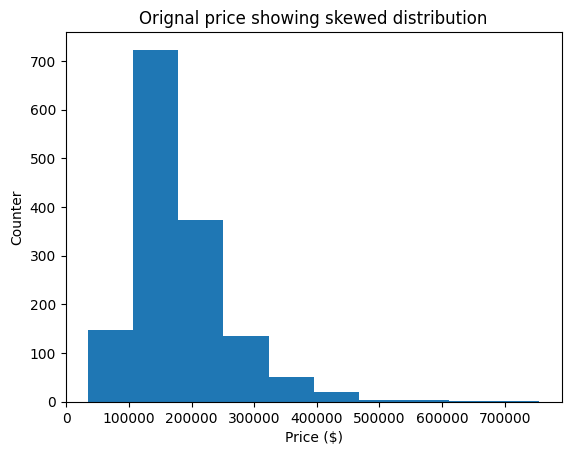

Text(0.5, 0, 'Price ($)')

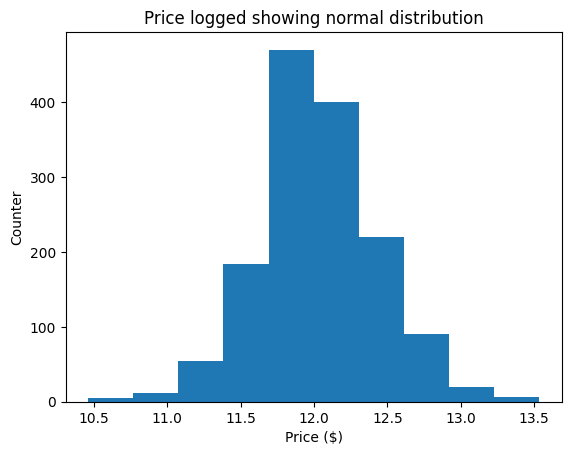

In [2]:
from bayesianFunction import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


if USE_DANISH_DATA:
    data = pd.read_csv('data/DanishHousingMarket.csv')
    data = df_basic_process(data)
else:
    data = pd.read_csv('data/train.csv')


if USE_DANISH_DATA: price = list(data.priceCash)
else: price = list(data.SalePrice)
plt.hist(price)
plt.title('Orignal price showing skewed distribution')
plt.ylabel('Counter')
plt.xlabel('Price ($)')
plt.show()
plt.hist(np.log(price))
plt.title('Price logged showing normal distribution')
plt.ylabel('Counter')
plt.xlabel('Price ($)')

Functions which contain the functionality

In [3]:
import pickle

if USE_DANISH_DATA: 
    data['PriceLogged'] = list(np.log(np.array(list(data.priceCash)))) # log the price so it has a normal distribution
    X = data.drop(columns=['priceCash', 'PriceLogged'], errors='ignore')  # Drop target columns
else: 
    data['PriceLogged'] = list(np.log(np.array(list(data.SalePrice)))) # log the price so it has a normal distribution
    X = data.drop(columns=['SalePrice', 'PriceLogged'], errors='ignore')  # Drop target columns

y = data['PriceLogged']  # Use log-transformed price as target

# preprocess the data
X_df = preprocess_data(X=X, use_pca=False)

# filter out the column which are not considered important
if not USE_DANISH_DATA: 
    # important_features = find_best_features_with_lasso(X_df=X_df, y_df=y)
    # Load from pickle file
    with open("LassoImportantFeatures.pkl", "rb") as file:
        important_features = pickle.load(file)
  
    # important_features = ["GrLivArea", "OverallQual", "YearBuilt", "TotalBsmtSF"]
    X_df = X_df[important_features]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

summary, trace, housing_model = get_bayesian_posterior_distribution(X_train=X_train, y_train=y_train, sigma=50000)
housing_model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefficients, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.


coefficients ~ N(<constant>, <constant>)
   Intercept ~ N(0, 5e+04)
       sigma ~ N**+(0, 1)
       Price ~ N(f(coefficients, Intercept), sigma)

Residuals for the training data

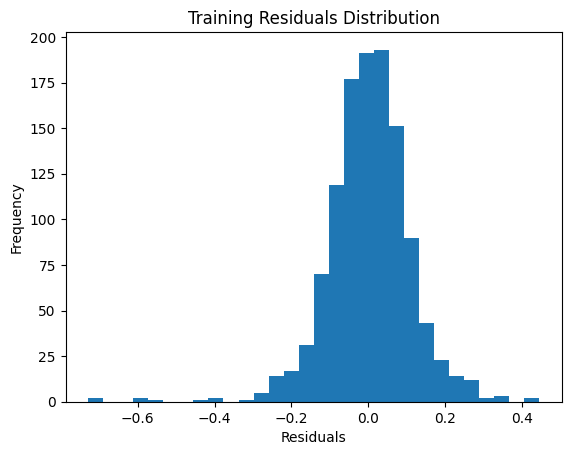

In [4]:
coefficients_mean = trace.posterior['coefficients'].mean(dim=('chain', 'draw')).values.flatten()
intercept_mean = trace.posterior['Intercept'].mean(dim=('chain', 'draw')).values
residuals = y_train - (X_train @ coefficients_mean + intercept_mean)
residuals = np.array(list(residuals))[np.where(np.array(list(residuals)) > -1)]

plt.hist(residuals, bins=30)
plt.title("Training Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


Using coefficients to find the most important features

In [5]:
best_features_coeffs = features_importance_analysis_coeffs(trace=trace, X_train=X_train)

if not USE_DANISH_DATA: 
    print(f'Lasso feature importance: {important_features}')
print(f'Bayesian feature importance (using Lasso features): {list(best_features_coeffs.feature_names)}')

best_features_coeffs.head(20)

Lasso feature importance: ['GrLivArea', 'Neighborhood_StoneBr', 'OverallQual', 'Neighborhood_Crawfor', 'Neighborhood_NridgHt', 'Exterior1st_BrkFace', 'CentralAir_Y', 'Condition1_Norm', 'Functional_Typ', 'GarageCars', 'YearBuilt', 'Neighborhood_Somerst', 'OverallCond', 'Foundation_PConc', 'BsmtExposure_Gd', 'SaleCondition_Partial', 'LotConfig_CulDSac', 'BsmtFullBath', 'BldgType_2fmCon', 'Fireplaces', 'YearRemodAdd', 'TotRmsAbvGrd', 'BsmtCond_TA', 'Neighborhood_NoRidge', 'GarageType_Attchd', 'ScreenPorch', 'WoodDeckSF', 'SaleCondition_Normal', 'Exterior1st_MetalSd', 'FullBath', 'LotArea', 'LandContour_HLS', 'HalfBath', 'LandContour_Lvl', 'Fence_MnPrv', 'BedroomAbvGr', 'ExterCond_TA', 'Neighborhood_BrkSide', 'PavedDrive_Y', 'GarageArea', '3SsnPorch', 'BsmtUnfSF', 'EnclosedPorch', 'LotShape_IR2', 'BsmtFinType1_GLQ', 'BsmtHalfBath', 'Neighborhood_ClearCr', 'Exterior2nd_Wd Sdng', '1stFlrSF', 'MasVnrArea', 'HeatingQC_TA', 'LotConfig_Inside', 'MiscVal', 'Id', 'YrSold', 'GarageYrBlt', 'LotShape

/Users/nikolastsalidis/Desktop/Otros/Universidad/Master/1st Semester/AdvStats/statisticsproject/bayesianFunction.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_features_coeffs['feature_names'] = important_features


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,feature_names
coefficients[1],0.127,0.023,0.084,0.170,0.001,0.0,2063.0,1621.0,1.0,Neighborhood_StoneBr
coefficients[0],0.108,0.009,0.089,0.123,0.000,0.0,1481.0,1438.0,1.0,GrLivArea
coefficients[3],0.105,0.015,0.077,0.135,0.000,0.0,2182.0,1314.0,1.0,Neighborhood_Crawfor
coefficients[4],0.098,0.017,0.064,0.129,0.000,0.0,2211.0,1404.0,1.0,Neighborhood_NridgHt
coefficients[5],0.090,0.014,0.063,0.117,0.000,0.0,2600.0,1580.0,1.0,Exterior1st_BrkFace
coefficients[18],0.090,0.029,0.038,0.146,0.001,0.0,1834.0,1662.0,1.0,BldgType_2fmCon
coefficients[2],0.086,0.005,0.076,0.096,0.000,0.0,2157.0,1439.0,1.0,OverallQual
coefficients[31],0.086,0.027,0.034,0.133,0.001,0.0,2018.0,1443.0,1.0,LandContour_HLS
coefficients[46],0.080,0.031,0.023,0.137,0.001,0.0,2196.0,1498.0,1.0,Neighborhood_ClearCr
coefficients[23],0.069,0.025,0.024,0.115,0.000,0.0,2546.0,1474.0,1.0,Neighborhood_NoRidge


Show the most important coefficients distributions

custom_names -->  ['Neighborhood_StoneBr', 'GrLivArea', 'Neighborhood_Crawfor', 'Neighborhood_NridgHt', 'Exterior1st_BrkFace', 'BldgType_2fmCon', 'OverallQual', 'LandContour_HLS', 'Neighborhood_ClearCr', 'Neighborhood_NoRidge', 'CentralAir_Y', 'Functional_Typ']


array([[<Axes: title={'center': 'coefficients\n1'}>,
        <Axes: title={'center': 'coefficients\n0'}>,
        <Axes: title={'center': 'coefficients\n3'}>],
       [<Axes: title={'center': 'coefficients\n4'}>,
        <Axes: title={'center': 'coefficients\n5'}>,
        <Axes: title={'center': 'coefficients\n18'}>],
       [<Axes: title={'center': 'coefficients\n2'}>,
        <Axes: title={'center': 'coefficients\n31'}>,
        <Axes: title={'center': 'coefficients\n46'}>],
       [<Axes: title={'center': 'coefficients\n23'}>,
        <Axes: title={'center': 'coefficients\n6'}>,
        <Axes: title={'center': 'coefficients\n8'}>]], dtype=object)

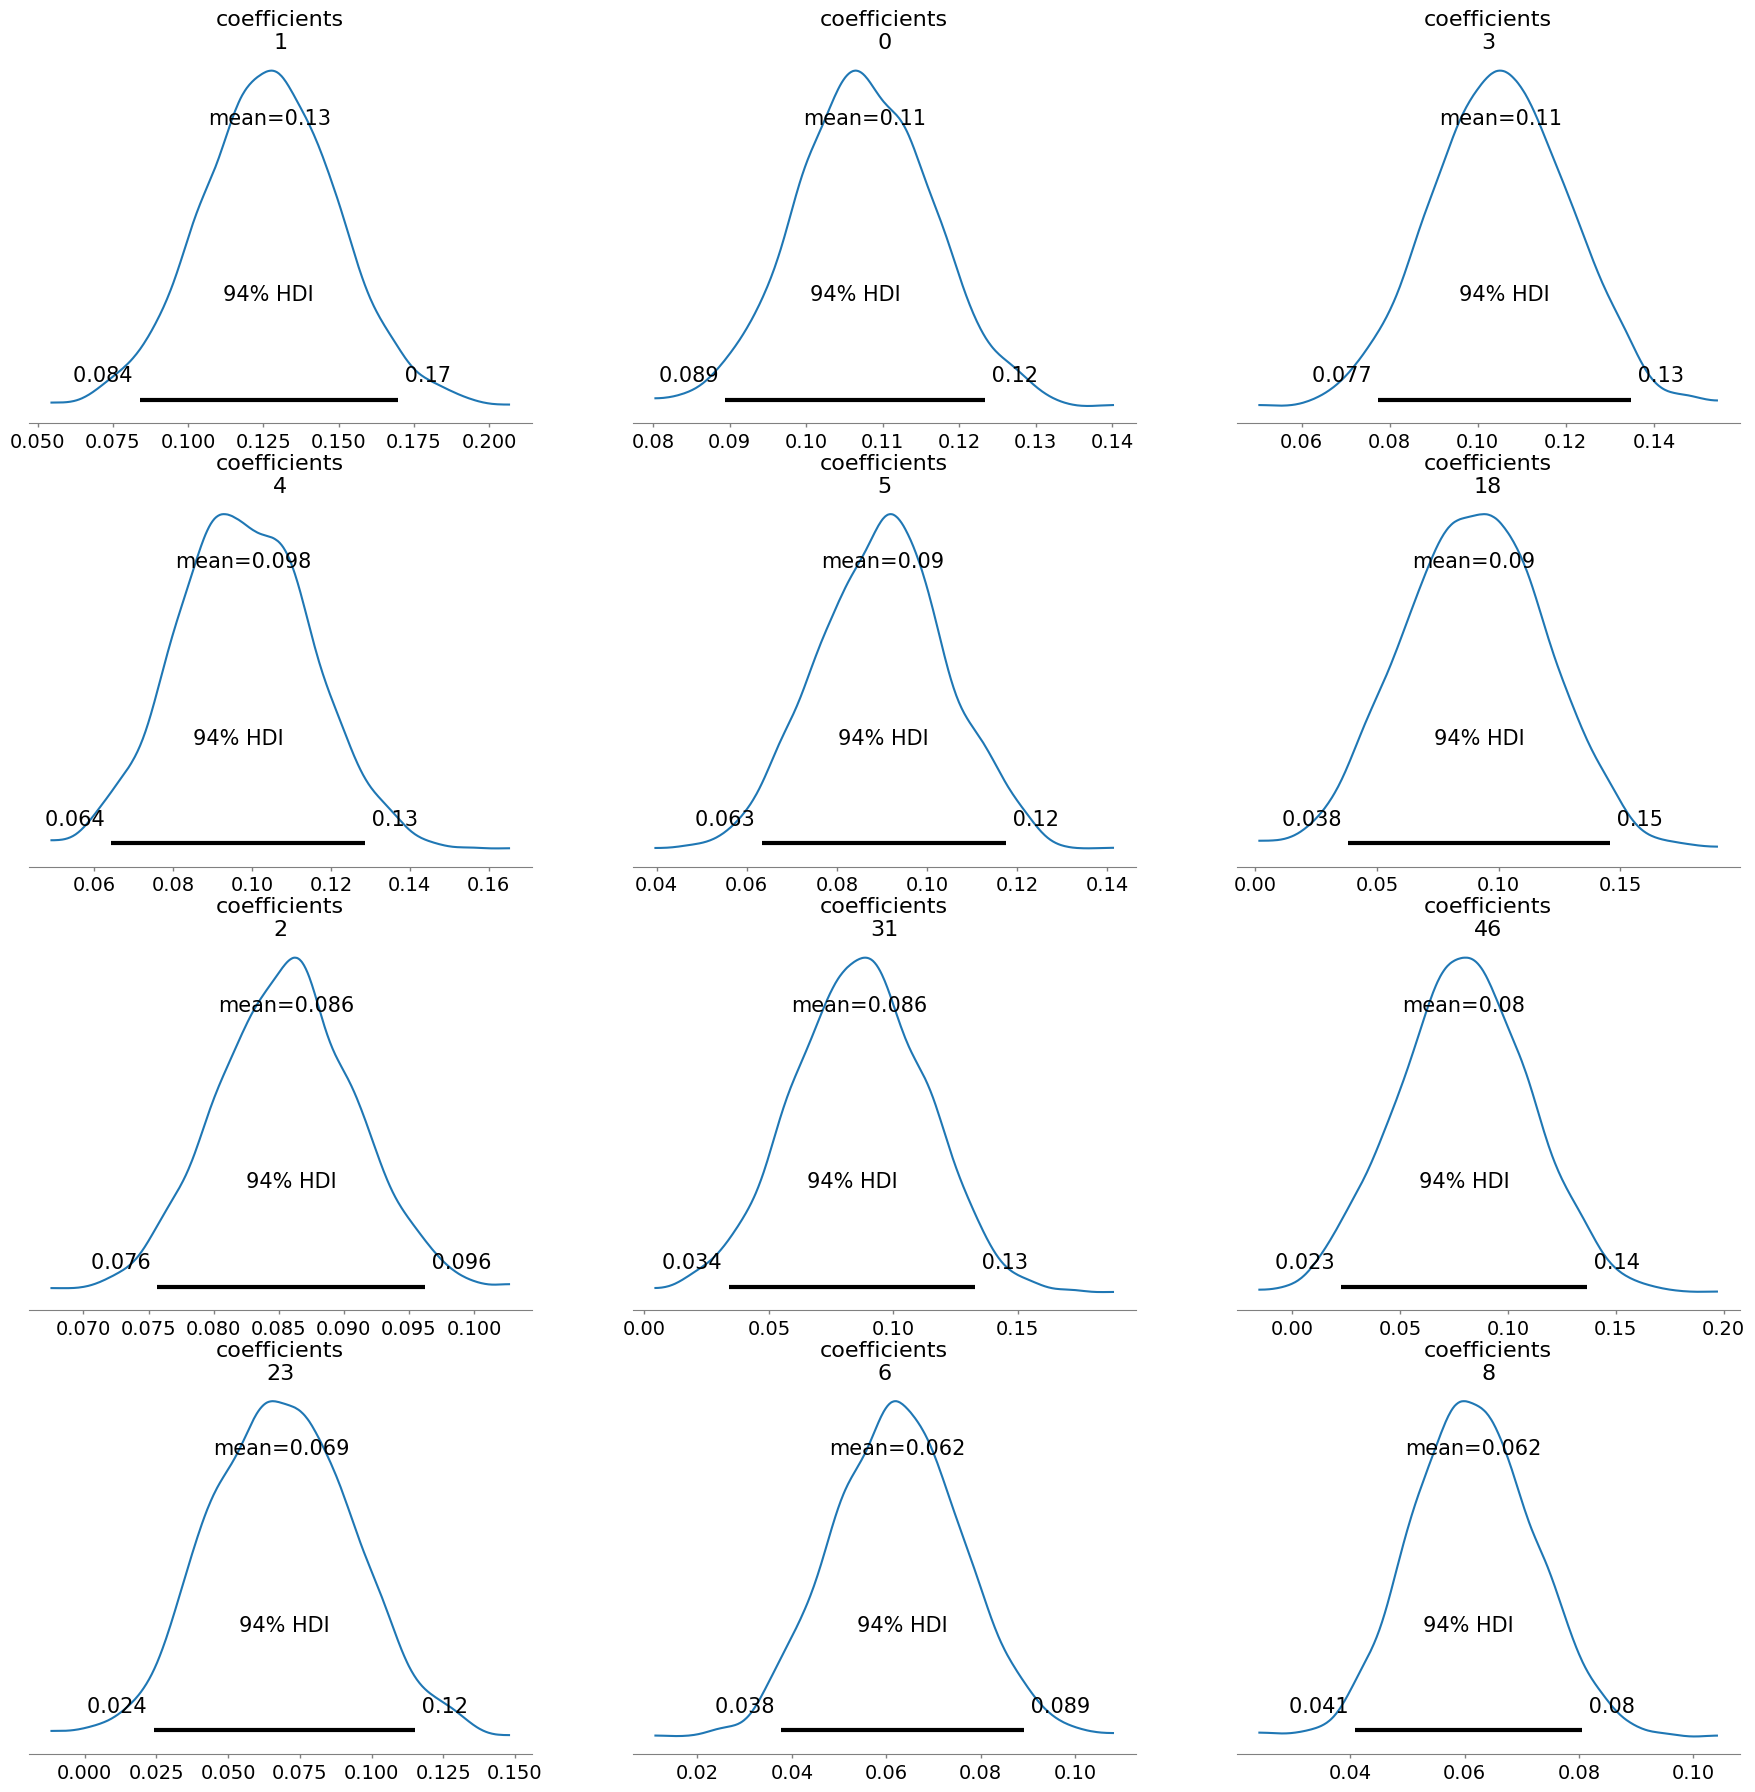

In [6]:
import arviz as az

# Use the var_names argument with index slicing
# az.plot_posterior(trace, var_names=["coefficients"], coords={"coefficients_dim_0": [0, 1, 2, 3, 4]})

custom_names = list(best_features_coeffs.head(12).feature_names)
print('custom_names --> ', custom_names)
coeffs_indeces = [int(i.split('[')[1].replace(']', '')) for i in best_features_coeffs.head(12).index]
az.plot_posterior(trace, var_names=["coefficients"], coords={"coefficients_dim_0": coeffs_indeces})

Make predictions and analyse its performance

Test Row 2: Predicted Mean = 103801.98, 95% CI = (99443.30, 108275.52)
	Actual Value --> 115000.0
		Pred actual diff --> -11198.02
Test Row 5: Predicted Mean = 86162.16, 95% CI = (82098.30, 90662.75)
	Actual Value --> 75500.0
		Pred actual diff --> 10662.16
Test Row 6: Predicted Mean = 257310.10, 95% CI = (242437.62, 272664.62)
	Actual Value --> 311500.0
		Pred actual diff --> -54189.9
Test Row 9: Predicted Mean = 145053.15, 95% CI = (137396.65, 153056.25)
	Actual Value --> 135500.0
		Pred actual diff --> 9553.15
Test Row 11: Predicted Mean = 118917.19, 95% CI = (113543.82, 124221.95)
	Actual Value --> 130000.0
		Pred actual diff --> -11082.81
Test Row 12: Predicted Mean = 96067.66, 95% CI = (89254.18, 103048.40)
	Actual Value --> 81000.0
		Pred actual diff --> 15067.66
Test Row 14: Predicted Mean = 172233.01, 95% CI = (165322.98, 179346.52)
	Actual Value --> 181000.0
		Pred actual diff --> -8766.99
Test Row 16: Predicted Mean = 194921.65, 95% CI = (187992.62, 202200.05)
	Actual Value 

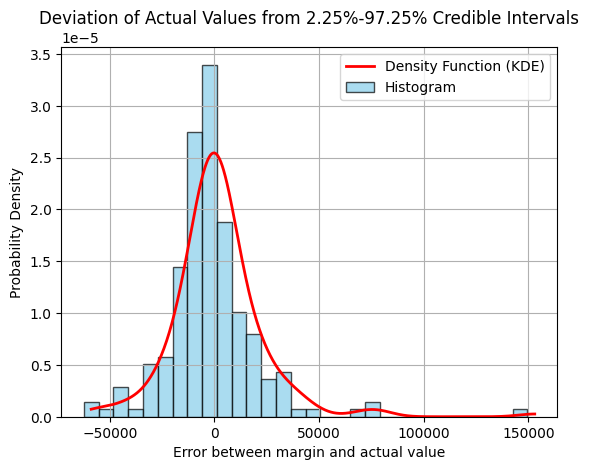

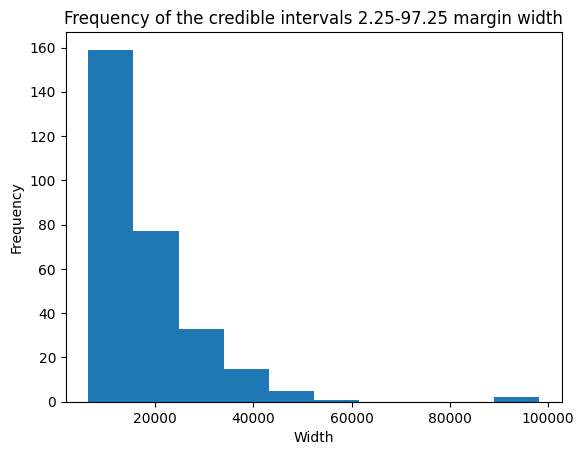

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def credible_intervals_margins_plot_analysis(predictions_outside_cri:dict, credible_intervals:list):
    # Data
    errors = list(predictions_outside_cri.values())

    # Calculate histogram values
    counts, bin_edges = np.histogram(errors, bins=30)
    bin_width = bin_edges[1] - bin_edges[0]  # Width of each bin

    # Normalize counts so area sums to 1
    normalized_counts = counts / (sum(counts) * bin_width)

    # Fit KDE to the data
    kde = gaussian_kde(errors)

    # Generate x values for KDE curve
    x_range = np.linspace(min(errors), max(errors), 1000)
    density = kde(x_range)

    # Plot the normalized histogram
    plt.bar(bin_edges[:-1], normalized_counts, width=bin_width, color='skyblue', alpha=0.7, edgecolor='black', label='Histogram')

    # Plot the KDE curve
    plt.plot(x_range, density, color='red', lw=2, label='Density Function (KDE)')

    # Add labels and legend
    plt.title(f'Deviation of Actual Values from 2.25%-97.25% Credible Intervals')
    plt.xlabel('Error between margin and actual value')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid()
    plt.show()

    plt.hist(credible_intervals[1] - credible_intervals[0])
    plt.title('Frequency of the credible intervals 2.25-97.25 margin width')
    plt.xlabel('Width')
    plt.ylabel('Frequency')    


def get_predictions(X_test, trace):
    # Convert X_test to NumPy and extract posterior samples
    X_test_np = X_test.values
    coefficients_samples = trace.posterior['coefficients'].values.reshape(-1, X_test_np.shape[1])
    intercept_samples = trace.posterior['Intercept'].values.flatten()

    # Compute predictions: dot product of coefficients and X_test, plus intercept
    predictions = np.dot(coefficients_samples, X_test_np.T) + intercept_samples[:, None]

    # unlog the different values
    predictions = np.round(np.exp(predictions))    

    # Calculate mean predictions and 95% credible intervals
    predicted_mean = predictions.mean(axis=0)
    credible_intervals = np.percentile(predictions, [2.5, 97.5], axis=0)
    # credible_intervals = np.percentile(predictions, [0, 100], axis=0)
    return predicted_mean, credible_intervals


def analyse_results(y_test, predicted_mean, credible_intervals):
    y_test_readjusted = np.round(np.exp(y_test))
    observations_prediction_cis_val = {}
    predictions_outside_cri = {}
    counter = 0

    # Display predictions with actual values
    for i, (mean, ci, actual) in enumerate(zip(predicted_mean, credible_intervals.T, y_test_readjusted)):
        l, u = ci[0], ci[1]
        observations_prediction_cis_val[counter] = False
        if actual >= l and actual <= u:
            observations_prediction_cis_val[counter] = True  
            # predictions_outside_cri[counter] = 0

        else:
            print(f"Test Row {i}: Predicted Mean = {mean:.2f}, 95% CI = ({l:.2f}, {u:.2f})")
            print(f"\tActual Value --> {actual}")
            print(f"\t\tPred actual diff --> {round(mean - actual, 2)}")
            predictions_outside_cri[counter] = -1*abs(l-actual) if min(abs(l-actual), abs(u-actual)) == abs(l-actual) else abs(u-actual)

        counter += 1

    # The variable credible_score_margins_accuracy represents the percentage of test observations where the 
    # actual target values fall within the 95% credible intervals predicted by the Bayesian model.
    # Accuracy of Uncertainty Estimates: credible_score_margins_accuracy measures how well the Bayesian model's credible intervals capture the actual target values. A high score indicates that the model’s uncertainty estimates are reliable and that the credible intervals are well-calibrated.
    # Why It Matters: In Bayesian modeling, providing uncertainty estimates (credible intervals) is as important as point predictions. This metric ensures that the predicted intervals are meaningful and consistent with the actual observations.
    credible_score_margins_accuracy = round(len(np.where(list(observations_prediction_cis_val.values()))[0]) / len(observations_prediction_cis_val) * 100, 2)

    # calculate the rmse
    rss = np.sum(np.square(y_test_readjusted - predicted_mean))
    mse = rss / len(y_test)
    rmse = np.sqrt(mse)

    relative_error = get_relative_error(y_true=np.array(list(y_test_readjusted)), y_pred=predicted_mean)

    print(f"\n\nMean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Relative Error: {relative_error}%")
    print(f"Percentage of target values that fall within the 95% credible intervals predicted by the Bayesian model: {credible_score_margins_accuracy}%")

    credible_intervals_margins_plot_analysis(predictions_outside_cri, credible_intervals)


predicted_mean, credible_intervals = get_predictions(X_test, trace)
analyse_results(y_test, predicted_mean, credible_intervals)

In [ ]:
# MCMC: NUTS
    # normal distribution for likelihood and prior
    # Mean Squared Error (MSE): 608221754.83
    # Root Mean Squared Error (RMSE): 24662.15
    # Percentage of target values that fall within the 95% credible intervals predicted by the Bayesian model: 42.47%

    # normal distribution for likelihood and prior II
    # Mean Squared Error (MSE): 608221094.16
    # Root Mean Squared Error (RMSE): 24662.14
    # Percentage of target values that fall within the 95% credible intervals predicted by the Bayesian model: 66.1%

    # normal distribution for likelihood and prior - without standardized data
    # Mean Squared Error (MSE): 1249154134.73
    # Root Mean Squared Error (RMSE): 35343.37
    # Percentage of target values that fall within the 95% credible intervals predicted by the Bayesian model: 21.23%

    # normal distribution for likelihood and prior - USING PCA WITH 10 COMPONENTS
    # Mean Squared Error (MSE): 886547854.03
    # Root Mean Squared Error (RMSE): 29774.95
    # Percentage of target values that fall within the 95% credible intervals predicted by the Bayesian model: 14.04%

    # normal distribution for likelihood and uniform for prior
    # Mean Squared Error (MSE): 607896162.91
    # Root Mean Squared Error (RMSE): 24655.55
    # Percentage of target values that fall within the 95% credible intervals predicted by the Bayesian model: 43.15%

    # StudentT distribution for likelihood and Laplace for prior
    # Mean Squared Error (MSE): 441388932.78
    # Root Mean Squared Error (RMSE): 21009.26
    # Percentage of target values that fall within the 95% credible intervals predicted by the Bayesian model: 39.38%

    # Normal distribution for likelihood and Laplace for prior
    # Mean Squared Error (MSE): 608269020.78
    # Root Mean Squared Error (RMSE): 24663.11
    # Percentage of target values that fall within the 95% credible intervals predicted by the Bayesian model: 41.1%

    # StudentT distribution for likelihood and Normal for prior
    # Mean Squared Error (MSE): 439892144.63
    # Root Mean Squared Error (RMSE): 20973.61
    # Percentage of target values that fall within the 95% credible intervals predicted by the Bayesian model: 39.73%

    # StudentT distribution for likelihood and Flat (jeffery's prior) for prior
    # Mean Squared Error (MSE): 440839043.65
    # Root Mean Squared Error (RMSE): 20996.17
    # Percentage of target values that fall within the 95% credible intervals predicted by the Bayesian model: 38.36%

    # StudentT distribution for likelihood and Normal for prior and Exponential for sigma
    # Mean Squared Error (MSE):1 7933246685602283.00
    # Root Mean Squared Error (RMSE): 89068775.03
    # Percentage of target values that fall within the 95% credible intervals predicted by the Bayesian model: 48.29%

    # StudentT distribution for likelihood and coefficient distribution based on the confidence intervals from the frequentist approach
    # Mean Squared Error (MSE): 440368109.89
    # Root Mean Squared Error (RMSE): 20984.95
    # Percentage of target values that fall within the 95% credible intervals predicted by the Bayesian model: 39.38%


# MCMC: Metropolis–Hastings
    # StudentT distribution for likelihood and coefficient distribution based on the confidence intervals from the frequentist approach
    # Mean Squared Error (MSE): 5946816449.93
    # Root Mean Squared Error (RMSE): 77115.60
    # Percentage of target values that fall within the 95% credible intervals predicted by the Bayesian model: 43.84%

Residuals for the testing data

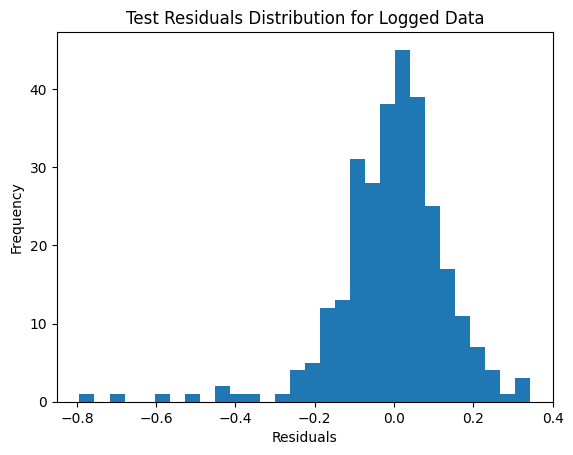

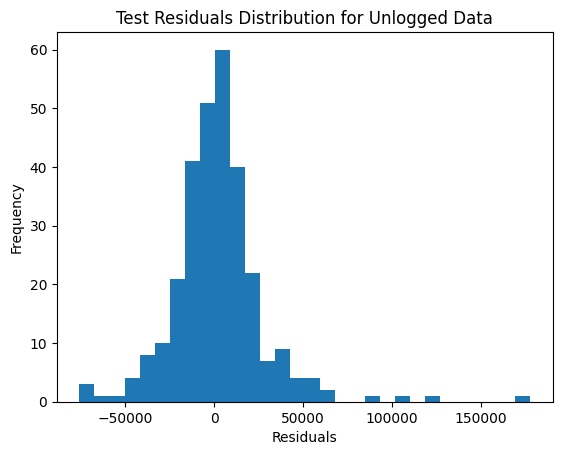

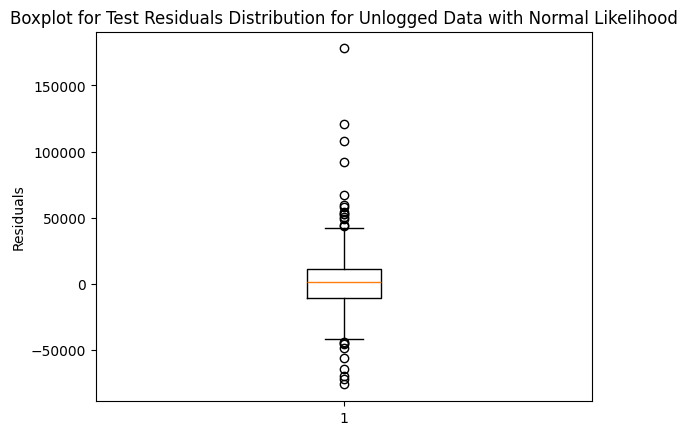

In [10]:
# test_residuals = np.round(np.exp(y_test)) - predicted_mean
test_residuals = y_test - np.log(predicted_mean)
plt.hist(test_residuals, bins=30)
plt.title("Test Residuals Distribution for Logged Data")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

test_residuals = np.round(np.exp(y_test)) - predicted_mean
plt.hist(test_residuals, bins=30)
plt.title("Test Residuals Distribution for Unlogged Data")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

plt.boxplot(test_residuals)
plt.title("Boxplot for Test Residuals Distribution for Unlogged Data with Normal Likelihood")
plt.ylabel("Residuals")
plt.show()

#### Conclusions

The combination of high RMSE and low credible interval coverage indicates that the model is not performing well:
It fails to make accurate point predictions (high RMSE).
It also fails to quantify uncertainty effectively (low credible interval coverage).

## Why use normal distribution for the priors:
Rationale: Normal priors are used here because they encode the belief that the parameter values are most likely to cluster around a central value (e.g., 0) but with some spread (controlled by the standard deviation, sigma).
- #### Why It's Relevant:
        - Most effects in real-world data tend to cluster around a central value (e.g., the effect of neighborhood or room size). The Normal distribution is flexible, allowing you to encode both uncertainty (using large sigma) and prior knowledge (using a specific mean, mu).

## Report section for explaining get_bayesian_posterior_distribution
The function get_bayesian_posterior_distribution(X_train: pd.DataFrame, y_train: pd.DataFrame) constructs and samples from a Bayesian linear regression model to estimate the posterior distributions of the model parameters. Specifically, it assumes that the target variable 
𝑦
train
y 
train
​
  follows a Normal distribution with a mean 
𝜇
μ, which is defined as a linear combination of the input features 
𝑋
train
X 
train
​
  and their corresponding weights (coefficients), plus an intercept term. Priors are placed on the model parameters: the coefficients and intercept are assigned weakly informative Normal distributions with mean 0 and standard deviation 10, while the residual standard deviation 
𝜎
σ is given a Half-Normal prior to enforce positivity. The likelihood function incorporates the observed target values to evaluate the probability of seeing the data given the current parameter estimates. Using Markov Chain Monte Carlo (MCMC) sampling, the function iteratively samples from the posterior distributions of the coefficients, intercept, and residual standard deviation. The resulting posterior summaries provide probabilistic estimates of the parameter values, including their means, standard deviations, and credible intervals, which quantify both the magnitude of the feature weights and the associated uncertainty.



#### Understanding: trace = pm.sample(1000, tune=1000, random_seed=42, cores=1)
The statement trace = pm.sample(1000, tune=1000, random_seed=42, cores=1) performs posterior sampling for the Bayesian model defined within the pm.Model() context. PyMC automatically identifies priors and the likelihood from the model components. Variables defined without the observed argument, such as the coefficients, intercept, and the residual standard deviation sigma, are treated as priors, representing prior beliefs about the model parameters. The likelihood, which includes the observed argument, connects the observed target data 
𝑦
train
y 
train
​
  to the model predictions (
𝜇
μ and 
𝜎
σ), evaluating how probable the data is given the current parameter values. During sampling, PyMC combines the priors and likelihood using Bayes’ theorem and employs algorithms like the No-U-Turn Sampler (NUTS) to efficiently explore the parameter space. The resulting samples, stored in trace, represent the posterior distributions of the model parameters, reflecting updated beliefs given the observed data.




### Model Assumptions and Justifications
The Bayesian regression model is designed to estimate housing prices based on a linear relationship between the input features and the target variable. Below, we provide detailed justifications for the choice of priors, the likelihood function, and the overall model structure, including why certain alternatives, such as uniform priors, were not used.

The priors for the coefficients and the intercept are modeled using Normal distributions with a mean of 0 and a standard deviation of 10. This choice reflects the prior belief that, before observing any data, the effects of the predictors (coefficients) and the baseline value (intercept) are centered around zero with moderate uncertainty. The mean of 0 assumes that the predictors initially have no significant influence on the target variable, while the standard deviation of 10 allows sufficient flexibility for large effects if the data supports it. This diffuse but weakly informative prior avoids imposing overly strong assumptions on the model.

We do not use uniform priors because they imply equal probability for all parameter values within a range, which can unintentionally result in overly large or unrealistic coefficients when the data is sparse or noisy. Uniform priors also lack regularization, which can lead to instability during sampling, particularly for high-dimensional models with many features. Normal priors, by contrast, provide a smoother and more realistic assumption about parameter behavior while incorporating flexibility for the observed data to guide the posterior estimates.

The linear model for the mean is defined as:
mu = dot(X_train, coefficients) + intercept

Here, the predictors in the training data are multiplied by their respective coefficients and combined with the intercept to compute the mean response. This formulation aligns with the assumption of a linear relationship between the features and the target variable, a common and interpretable approach in regression modeling. It allows us to quantify and interpret the contribution of each predictor directly.

The prior for the residual standard deviation, sigma, is modeled using a Half-Normal distribution with a standard deviation of 10. The Half-Normal prior is appropriate because sigma represents the standard deviation of the residuals and cannot be negative. This prior assumes that smaller values of sigma are more likely but allows for larger values when supported by the data. Alternatives such as uniform priors were avoided because they provide no constraint on the residual variability and could lead to instability during sampling. The Half-Normal prior balances simplicity and flexibility while remaining consistent with the non-negativity of sigma.

The likelihood function uses a Normal distribution to model the observed target values:
price_obs = Normal('Price', mu=mu, sigma=sigma, observed=y_train)

The Normal likelihood assumes that the observed log-transformed prices are distributed around the predicted mean with residual variability described by sigma. This choice is justified because the log transformation applied to the prices ensures approximate normality of the response variable, which aligns with the Gaussian assumption of the likelihood. Using a Normal distribution simplifies the computations and provides a natural connection to linear regression. Alternatives like the Gamma or Student-t distribution could be considered for skewed or heavy-tailed data, but the log transformation sufficiently addresses these issues in this case.

To estimate the model parameters, the No-U-Turn Sampler (NUTS), a variant of Markov Chain Monte Carlo (MCMC), is used. PyMC automatically identifies all stochastic variables, including the priors for coefficients, intercept, and sigma, and incorporates them into the sampling process. The likelihood function ensures that the observed data informs the posterior distributions of these parameters, balancing prior beliefs with evidence from the data.

In summary, the priors for the coefficients, intercept, and sigma are chosen to provide weakly informative yet realistic assumptions about the parameters. Normal priors avoid the instability of uniform priors while allowing the observed data to guide the posterior estimates. The linear model structure and the Normal likelihood are well-suited to the log-transformed response variable, ensuring computational stability and interpretability of the results.